# My first Autoencoder for Jet compression

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot

In [2]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Getting the data
I will only use $p_T, \eta, \phi \text{ and } E$.

In [4]:
path_to_data = '../../data/'

folder15 = 'breynold/user.breynold.data15_13TeV.00284484.physics_Main.DAOD_NTUP_JTRIG_JETM1.r9264_p3083_p3601_j042_tree.root/'
file15 = 'user.breynold.18753218._000001.tree.root'
folder16 = 'breynold/user.breynold.data16_13TeV.00307656.physics_Main.DAOD_NTUP_JTRIG_JETM1.r9264_p3083_p3601_j042_tree.root/'
file16 = 'user.breynold.18797259._000001.tree.root'

# Load a ROOT file
filePath = path_to_data + folder16 + file16
ttree = uproot.open(filePath)['outTree']['nominal']

In [5]:
branchnames = ['nAntiKt4EMTopoJets_Calib2018',
               'AntiKt4EMTopoJets_Calib2018_E',
               'AntiKt4EMTopoJets_Calib2018_pt',
               'AntiKt4EMTopoJets_Calib2018_phi',
               'AntiKt4EMTopoJets_Calib2018_eta']

jaggedE = ttree.array(branchnames[1])
jaggedpT = ttree.array(branchnames[2])
jaggedphi = ttree.array(branchnames[3])
jaggedeta = ttree.array(branchnames[4])

In [6]:
def get_leading(jaggedX):
    return jaggedX[jaggedX.counts > 1, 0]

In [7]:
leading_E = get_leading(jaggedE)
leading_pT = get_leading(jaggedpT)
leading_phi = get_leading(jaggedphi)
leading_eta = get_leading(jaggedeta)

In [8]:
print(leading_E.shape, leading_eta.shape, leading_phi.shape, leading_pT.shape)

(1937902,) (1937902,) (1937902,) (1937902,)


In [9]:
df = pd.DataFrame(data = {'pT': leading_pT, 'eta': leading_eta, 'phi': leading_phi, 'E': leading_E})

## Splitting into training and test sets

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# Save train and test sets
# train.to_pickle('processed_data/train.pkl')
# test.to_pickle('processed_data/test.pkl')
# train = pd.read_pickle('processed_data/train.pkl')
# test = pd.read_pickle('processed_data/test.pkl')

n_features = len(train.loc[0])

In [12]:
print(train.shape, test.shape)

(1550321, 4) (387581, 4)


In [13]:
# Normalize the features
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std  # Is this the right way to normalize? (only using train mean and std to normalize both train and test)

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Building models

I'm building three models of different sizes. The smallest one does not do any compression but acts as a control model. If that one isn't preforming well the larger models probably don't stand a chance either.

### Small model

In [14]:
model = nn.Sequential(
    nn.Linear(n_features, 4),
    nn.Tanh(),
    nn.Linear(4, n_features),
)

### Medium model

In [40]:
model_medium = nn.Sequential(
    nn.Linear(n_features, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 4),
    nn.Tanh(),
    nn.Linear(4, n_features),
)

### Large model

In [16]:
model_big = nn.Sequential(
    nn.Linear(n_features, 8),
    nn.Tanh(),
    nn.Linear(8, 6),
    nn.Tanh(),
    nn.Linear(6, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 4),
    nn.Tanh(),
    nn.Linear(4, 6),
    nn.Tanh(),
    nn.Linear(6, 8),
    nn.Tanh(),
    nn.Linear(8, n_features),
)

In [17]:
# Some helper functions
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)  # MSE-Loss
        if(epoch % 1 == 0):
            print('epoch: ' + str(epoch) + ',', 'validation loss: ' + str(val_loss))

In [18]:
bs = 64  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

## Training

In [19]:
epochs = 7
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.000736557113063001
epoch: 1, validation loss: 0.00033792929832384495
epoch: 2, validation loss: 0.00030191991597372736
epoch: 3, validation loss: 0.0001535313171534736
epoch: 4, validation loss: 0.0001386966590495777
epoch: 5, validation loss: 0.00010972093781220296
epoch: 6, validation loss: 0.001541099412597634


In [20]:
epochs = 3
opt = optim.Adam(model.parameters(), lr=3e-4)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 8.760630124097094e-05
epoch: 1, validation loss: 8.441838015709016e-05
epoch: 2, validation loss: 7.041108092644634e-05


In [21]:
epochs = 2
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 6.962559175108803e-05
epoch: 1, validation loss: 6.961878245008718e-05


### Look at reconstructed input vs input

In [22]:
model.eval()
for ii in np.arange(100, 110):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6907, -0.6983,  1.7019,  0.2675], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1736, -0.1691, -0.0312, -0.6007], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3759,  0.6486,  1.3047, -0.5481], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3714, -0.0104,  1.0892, -0.7333], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7793, -0.3967,  1.1515, -0.7706], grad_fn=<AddBackward0>)
 
Inp: tensor([0.4060, 1.5628, 1.4620, 1.8385])
Out: tensor([0.4078, 1.5753, 1.4694, 1.8361], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.0816, -0.7146, -1.2172, -0.3813])
Out: tensor([-0.0785, -0.7128, -1.2190, -0.3872], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.4208,  0.0398, -1.2887, -0.5597])
Out: tensor([ 0.4245,  0.0341, -1.2950, -0.5606], grad_fn=<AddBackward0>)
 


In [23]:
idxs = (4000, 4010)  # Choose events to compare
#Get some data for comparison
data = valid_ds.tensors[0][idxs[0]:idxs[1]]
pred = model(data).detach().numpy()

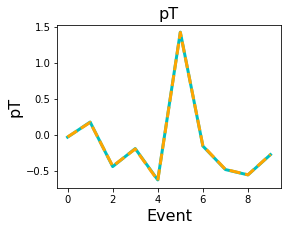

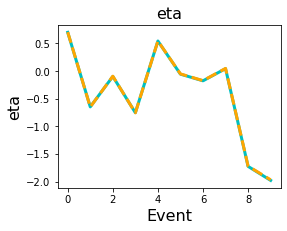

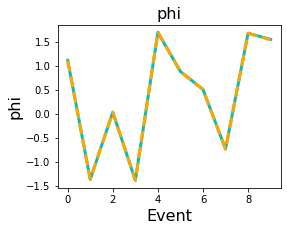

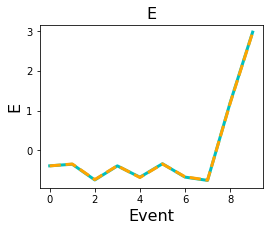

In [24]:
# Plot input on top of output
linewd = 3
line_style = ['-', '--']
colors = ['c', 'orange']
fontsz = 16
figsz = (4, 3)
for kk in np.arange(4):
    plt.figure(kk, figsize=figsz)
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], linewidth=linewd)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], linewidth=linewd)
    plt.title(df.columns[kk], fontsize=fontsz)
    plt.xlabel('Event', fontsize=fontsz)
    plt.ylabel(df.columns[kk], fontsize=fontsz)

## Train medium model

In [42]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
#lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
#for ii, epochs in enumerate(epochs_list):
#    print('Setting learning rate to %.1e' % lrs[ii])
#    opt = optim.Adam(model_medium.parameters(), lr=lrs[ii])
#    fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

Setting learning rate to 1.0e-03
epoch: 0, validation loss: 0.006086880177678167
epoch: 1, validation loss: 0.0039107180646617565
epoch: 2, validation loss: 0.003350690021453632
epoch: 3, validation loss: 0.0032729979791548056
epoch: 4, validation loss: 0.002797499309866681
epoch: 5, validation loss: 0.0026659385785072114
epoch: 6, validation loss: 0.002465859215869848
Setting learning rate to 3.0e-04
epoch: 0, validation loss: 0.0023404878509778243
epoch: 1, validation loss: 0.0022599794968717374
epoch: 2, validation loss: 0.002125246077403564
epoch: 3, validation loss: 0.0020363941449962697
epoch: 4, validation loss: 0.002051722268667014
Setting learning rate to 1.0e-04
epoch: 0, validation loss: 0.0019300546055246697
epoch: 1, validation loss: 0.0019675536142809117
epoch: 2, validation loss: 0.0018746047096876103
Setting learning rate to 3.0e-05
epoch: 0, validation loss: 0.0018605685620107898
epoch: 1, validation loss: 0.0018462709365027214
Setting learning rate to 1.0e-05
epoch: 0

In [25]:
epochs = 7
loss_func = nn.MSELoss()
opt = optim.Adam(model_medium.parameters(), lr=1e-3)
fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.004773648594269232
epoch: 1, validation loss: 0.0030309859306544363
epoch: 2, validation loss: 0.002172103714699364
epoch: 3, validation loss: 0.003066309637726141
epoch: 4, validation loss: 0.0015322377849005264
epoch: 5, validation loss: 0.0014684152945342716
epoch: 6, validation loss: 0.0011886528151028156


In [26]:
epochs = 4
loss_func = nn.MSELoss()
opt = optim.Adam(model_medium.parameters(), lr=3e-4)
fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0011125588414966955
epoch: 1, validation loss: 0.0010642724230004856
epoch: 2, validation loss: 0.0010329516460837553
epoch: 3, validation loss: 0.0010277904099933242


In [27]:
epochs = 3
loss_func = nn.MSELoss()
opt = optim.Adam(model_medium.parameters(), lr=1e-4)
fit(epochs, model_medium, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0010148659788744667
epoch: 1, validation loss: 0.000942294752626167
epoch: 2, validation loss: 0.0009353808261164761


In [28]:
model_medium.eval()
# Print a few tensors
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_medium(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.7136, -0.7015,  1.6770,  0.2502], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1693, -0.1639, -0.0199, -0.5847], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3679,  0.6483,  1.3108, -0.5514], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3697, -0.0088,  1.1099, -0.7179], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7749, -0.3935,  1.1703, -0.7481], grad_fn=<AddBackward0>)
 


In [29]:
#Get some data for comparison
data = valid_ds.tensors[0][idxs[0]:idxs[1]]
pred_medium = model_medium(data).detach().numpy()

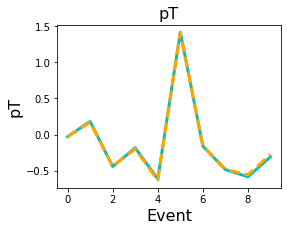

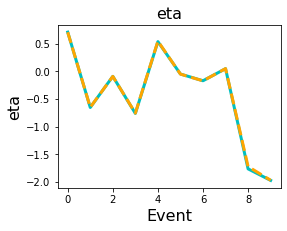

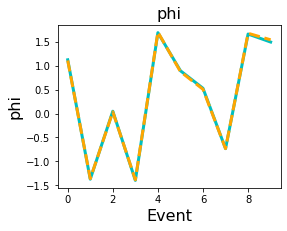

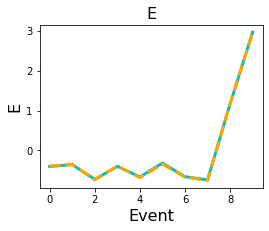

In [30]:
# Plot input on top of output
linewd = 3
line_style = ['-', '--']
colors = ['c', 'orange']
fontsz = 16
figsz = (4, 3)
for kk in np.arange(4):
    plt.figure(kk, figsize=figsz)
    plt.plot(pred_medium[:, kk], color=colors[0], label='Output', linestyle=line_style[0], linewidth=linewd)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], linewidth=linewd)
    plt.title(df.columns[kk], fontsize=fontsz)
    plt.xlabel('Event', fontsize=fontsz)
    plt.ylabel(df.columns[kk], fontsize=fontsz)

## Train big model

In [31]:
epochs = 5
loss_func = nn.MSELoss()
opt = optim.Adam(model_big.parameters(), lr=1e-3)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0023079907329286724
epoch: 1, validation loss: 0.0008924777925893498
epoch: 2, validation loss: 0.0007440450185393244
epoch: 3, validation loss: 0.00033590610247258794
epoch: 4, validation loss: 0.0008517879722089027


In [32]:
epochs = 3
opt = optim.Adam(model_big.parameters(), lr=3e-4)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.00020896033510371084
epoch: 1, validation loss: 0.00018475928979071326
epoch: 2, validation loss: 0.0001648752825392663


In [33]:
epochs = 3
opt = optim.Adam(model_big.parameters(), lr=1e-4)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0001541565741138469
epoch: 1, validation loss: 0.00012935275649805802
epoch: 2, validation loss: 0.00013058569378918944


In [34]:
epochs = 2
opt = optim.Adam(model_big.parameters(), lr=3e-5)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.00011777593524407403
epoch: 1, validation loss: 0.00011672351230738502


In [35]:
epochs = 2
opt = optim.Adam(model_big.parameters(), lr=1e-5)
fit(epochs, model_big, loss_func, opt, train_dl, valid_dl)

epoch: 0, validation loss: 0.0001148705360640724
epoch: 1, validation loss: 0.00011454058629062384


In [36]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/model_big.pt'  # Last save had valid loss = 9.8e-5
#torch.save(model_big.state_dict(), save_path)
# model_big = nn.Sequential()
# model_big.load_state_dict(torch.load(save_path))
# model.eval()

In [37]:
model_big.eval()
# Print a few tensors
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_big(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6694, -0.7080,  1.6755,  0.2910], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1822, -0.1617, -0.0345, -0.5981], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3825,  0.6453,  1.3111, -0.5498], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3688, -0.0102,  1.0888, -0.7315], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7768, -0.3949,  1.1523, -0.7668], grad_fn=<AddBackward0>)
 


In [38]:
#Get some data for comparison
data = valid_ds.tensors[0][idxs[0]:idxs[1]]
pred_big = model_big(data).detach().numpy()

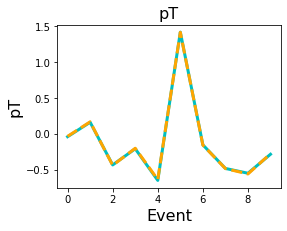

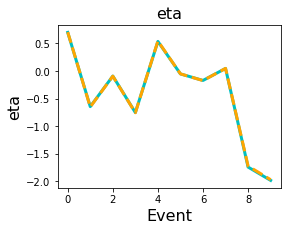

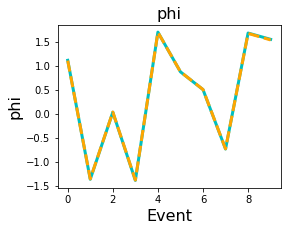

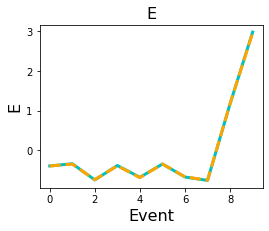

In [39]:
# Plot reconstructed input on top of output
linewd = 3
line_style = ['-', '--']
colors = ['c', 'orange']
fontsz = 16
figsz = (4, 3)
for kk in np.arange(4):
    plt.figure(kk, figsize=figsz)
    plt.plot(pred_big[:, kk], color=colors[0], label='Output', linestyle=line_style[0], linewidth=linewd)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], linewidth=linewd)
    plt.title(df.columns[kk], fontsize=fontsz)
    plt.xlabel('Event', fontsize=fontsz)
    plt.ylabel(df.columns[kk], fontsize=fontsz)